In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import shutil

In [3]:
train_dir = '/kaggle/input/standard-ocr-dataset/data/training_data'
test_dir = '/kaggle/input/standard-ocr-dataset/data/testing_data'

print(f"Training samples: {len(os.listdir(train_dir))}")
print(f"Classes: {os.listdir(train_dir)}")

Training samples: 36
Classes: ['N', '7', 'R', '2', 'B', 'I', 'F', 'H', '5', 'E', 'U', 'M', '8', 'X', '0', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', '3', '1', 'C', '4', 'P', '9', 'L', '6', 'W', 'D', 'J']


In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import shutil

# Paths
train_dir = '/kaggle/input/standard-ocr-dataset/data/training_data'
new_test_dir = '/kaggle/working/new_test_data'

# Create new test directory
os.makedirs(new_test_dir, exist_ok=True)

# Collect all training files
all_files = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for fname in os.listdir(class_path):
        all_files.append((os.path.join(class_path, fname), class_name))

# Split 15% for new test set
train_files, test_files = train_test_split(all_files, test_size=0.15, random_state=42)

# Copy test files to new directory
for file_path, class_name in test_files:
    class_dir = os.path.join(new_test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    shutil.copy(file_path, class_dir)

# Load new datasets
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
new_test_ds = tf.keras.utils.image_dataset_from_directory(
    new_test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 3095 files belonging to 36 classes.


I0000 00:00:1761157923.780549      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761157923.781248      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
import os
import shutil

# Define new train directory
new_train_dir = '/kaggle/working/new_train_data'

# Copy train files to new_train_dir
for file_path, class_name in train_files:
    class_dir = os.path.join(new_train_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    shutil.copy(file_path, class_dir)

print(f"Copied {len(train_files)} files to {new_train_dir}")

Copied 17533 files to /kaggle/working/new_train_data


In [6]:
new_train_ds = tf.keras.utils.image_dataset_from_directory(
    new_train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=42
)

Found 17533 files belonging to 36 classes.


In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

# Class names
class_names = test_ds.class_names
print(f"Number of classes: {len(class_names)}")
print("Class names:", class_names)

Found 1008 files belonging to 36 classes.
Number of classes: 36
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


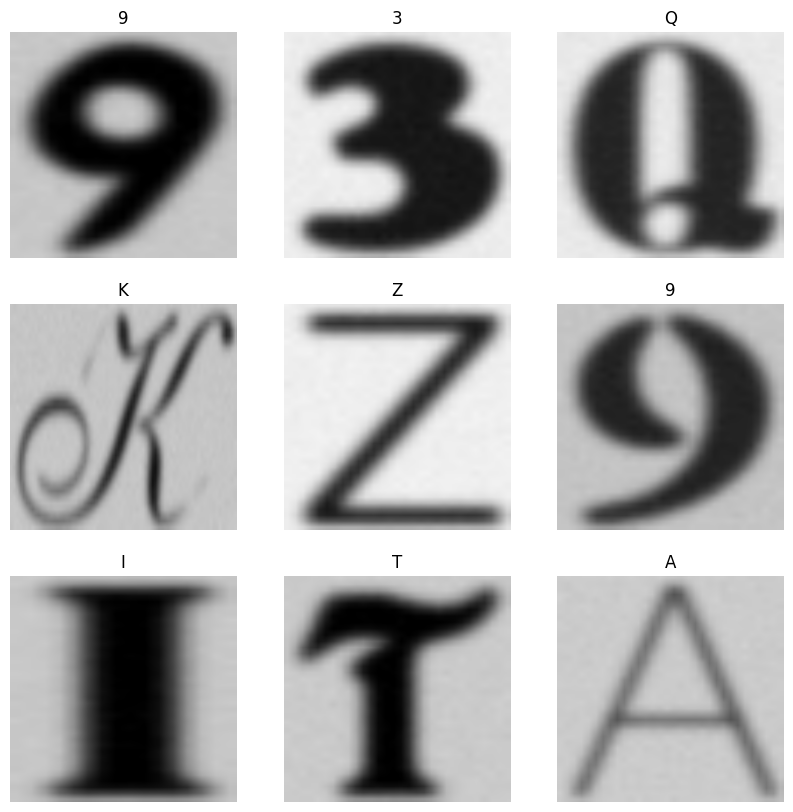

In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = new_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [9]:
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Add custom head for classification
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names), activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,596 (9.26 MB)

 Trainable params: 168,612 (658.64 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

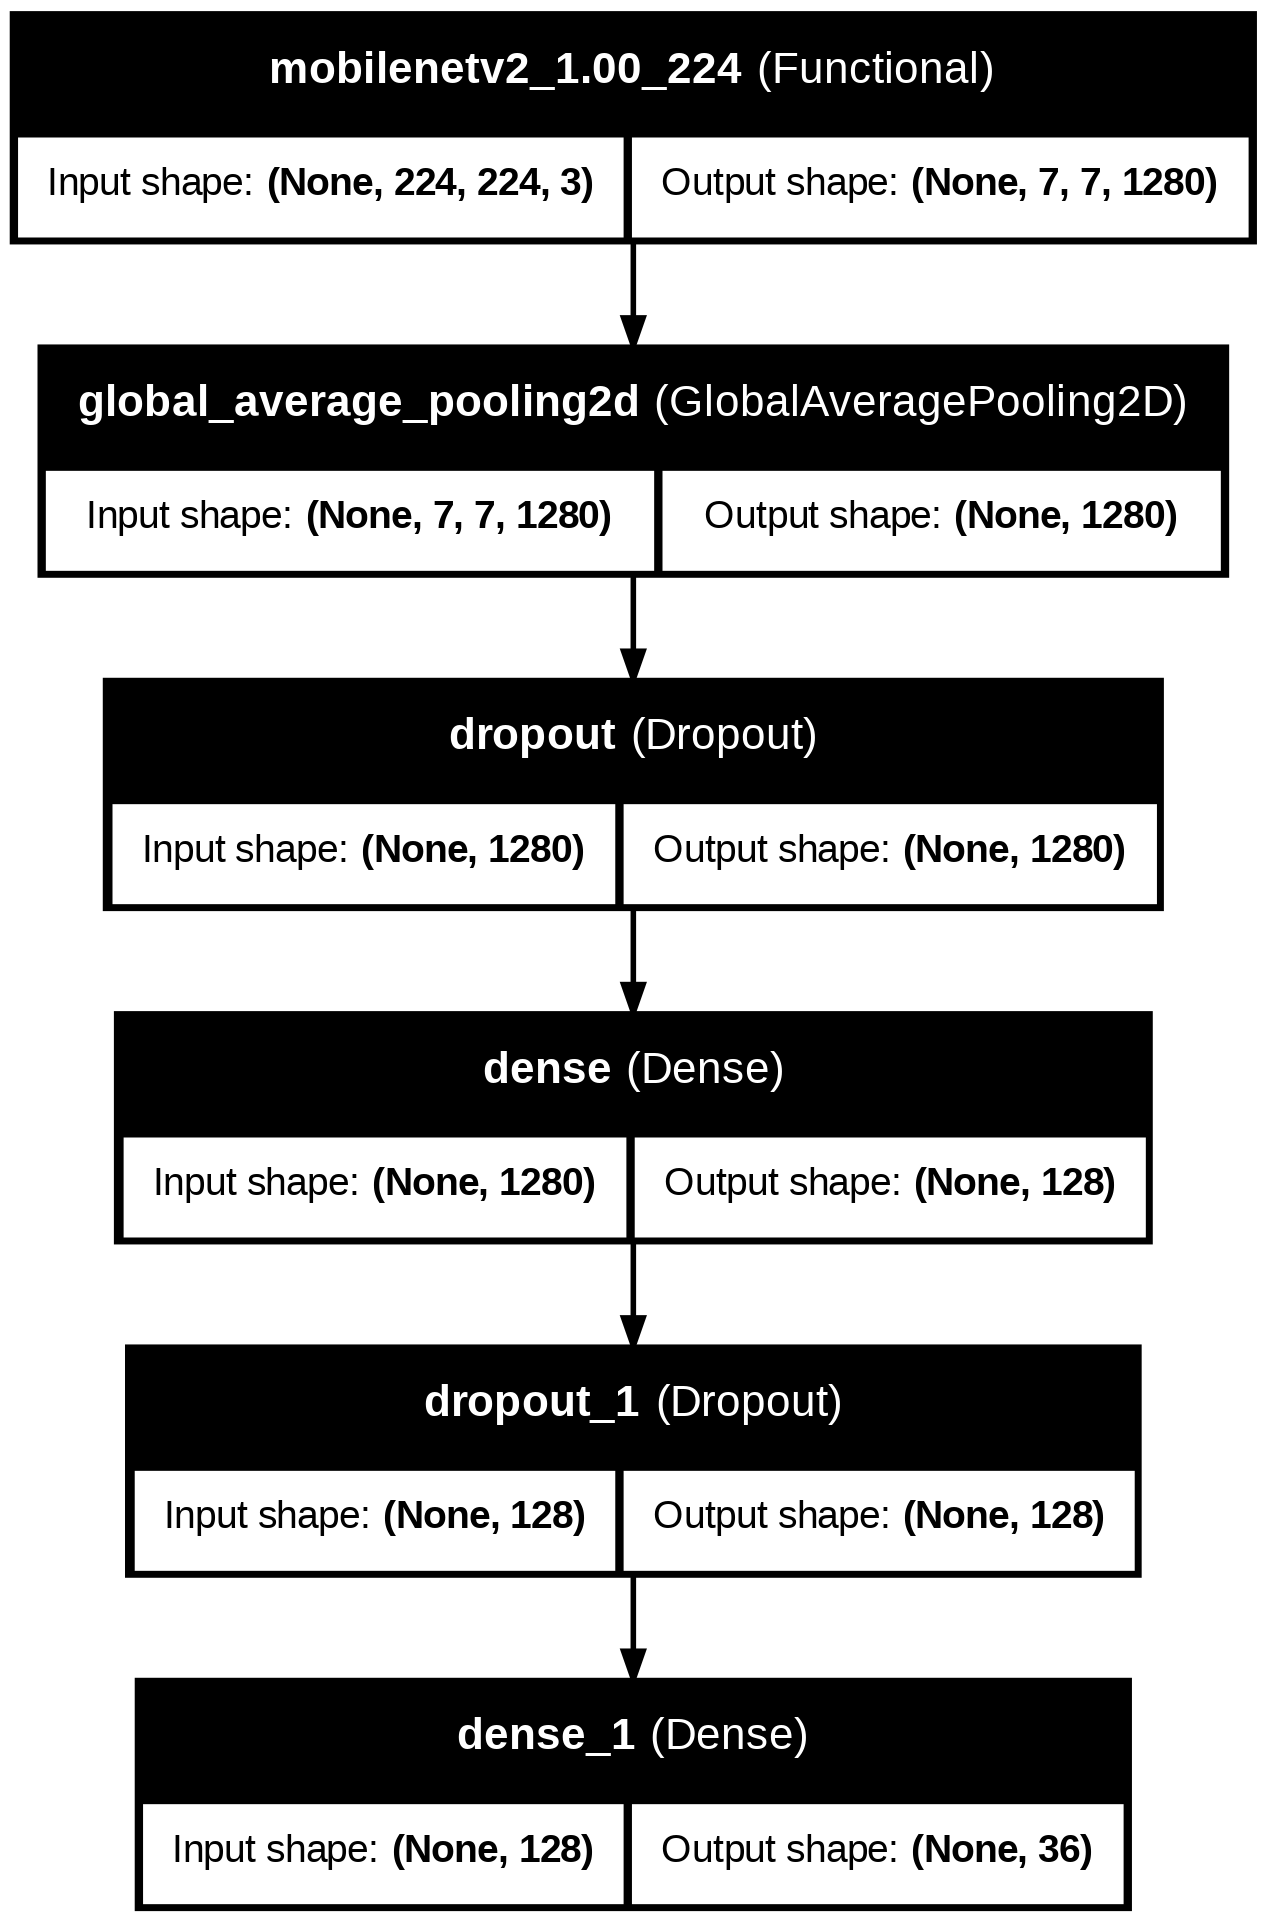

In [11]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train model with optimized settings
history = model.fit(
    new_train_ds,
    epochs=50,
    validation_data=new_test_ds,  # Use validation dataset, not test
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50


I0000 00:00:1761158118.949393     107 service.cc:148] XLA service 0x7c8050013950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761158118.950414     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761158118.950432     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761158119.832079     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/548 ━━━━━━━━━━━━━━━━━━━━ 1:07 124ms/step - accuracy: 0.0078 - loss: 4.0108     

I0000 00:00:1761158124.659666     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


548/548 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.3624 - loss: 2.3130 - val_accuracy: 0.8472 - val_loss: 0.6073
Epoch 2/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.7596 - loss: 0.8142 - val_accuracy: 0.8869 - val_loss: 0.4422
Epoch 3/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8110 - loss: 0.6274 - val_accuracy: 0.9015 - val_loss: 0.3590
Epoch 4/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8500 - loss: 0.5080 - val_accuracy: 0.9134 - val_loss: 0.3031
Epoch 5/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8568 - loss: 0.4597 - val_accuracy: 0.9137 - val_loss: 0.3004
Epoch 6/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8663 - loss: 0.4321 - val_accuracy: 0.9186 - val_loss: 0.2765
Epoch 7/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.8739 - loss: 0.4015 - val_accuracy: 0.9273 - val_loss: 0.2538
Epoch 8/50
548/548 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.8826 - loss: 0.3754 - val_accurac

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2%}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9713 - loss: 0.1131
Test Accuracy: 96.23%


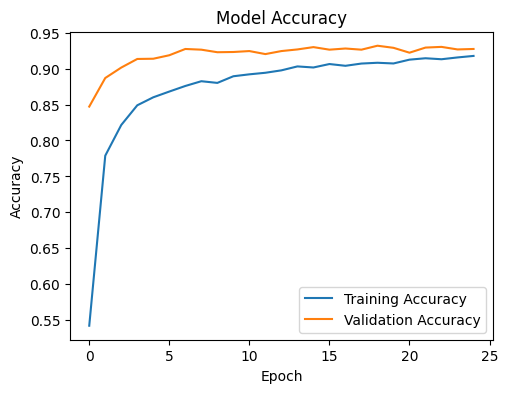

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

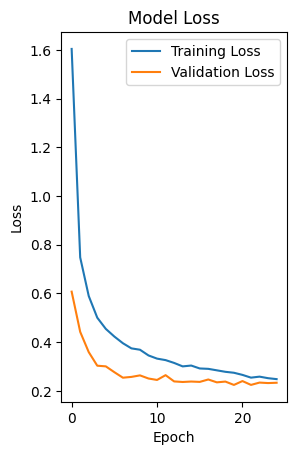

In [15]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()